### This notebook aims to create word embeddings based on eligibility criteria for oncology clinical trials on clinicaltrials.gov using Google's BERT.


# 1. Loading Pre-Trained BERT

Install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) 

We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

If you're running this code on Google Colab, you will have to install this library each time you reconnect; the following cell will take care of that for you.

In [18]:
import pandas as pd
import os

In [1]:
#!pip install pytorch-pretrained-bert

Now let's import 
- pytorch
- pretrained BERT model
- BERT tokenizer

This is the pre-trained model released by Google that ran for many, many hours on Wikipedia and [Book Corpus](https://arxiv.org/pdf/1506.06724.pdf), a dataset containing +10,000 books of different genres. 

__This model is responsible (with a little modification) for beating NLP benchmarks across a range of tasks. Google released a few variations of BERT models__ 

The one we'll use here is the smaller of the two available sizes ("base" and "large") and ignores casing, hence "uncased.""

In [2]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# 2. Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we will need:

- special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
- tokens that conforms with the fixed vocabulary used in BERT
- token IDs from BERT's tokenizer
- mask IDs to indicate which elements in the sequence are tokens and which are padding elements
- segment IDs used to distinguish different sentences
- positional embeddings used to show token position within the sequence

Luckily, this interface takes care of some of these input specifications for us so we will only have to manually create a few of them (we'll revisit the other inputs in another tutorial).




## 2.1. Special Tokens
BERT can take as input either one or two sentences, and expects special tokens to mark the beginning and end of each one:

**2 Sentence Input**:

`[CLS] The man went to the store. [SEP] He bought a gallon of milk. [SEP]`

**1 Sentence Input**:

`[CLS] The man went to the store. [SEP]`



## 2.2. Tokenization

BERT provides its own tokenizer, which we imported above. Let's see how it handles the below sentence.

In [16]:
data_root = '/home/ubuntu/datasets/cancer-clinical-trials-eligibility/input_for_bert/'

In [23]:
elig_txt = pd.read_csv(os.path.join(data_root,"unlabelled_eligibility.txt"), header=None,index_col=False)

In [24]:
elig_txt.shape

(1000000, 1)

In [25]:
elig_txt.head(5)

0
0  study interventions are recombinant CD40-ligan...
1  study interventions are Liposomal doxorubicin ...
2  study interventions are BI 836909 . multiple m...
3  study interventions are Immunoglobulins . recu...
4  study interventions are Paclitaxel . stage ova...

In [27]:
elig_txt[0] = elig_txt[0].astype(str)+" [SEP]"

In [36]:
elig_txt.values[0], elig_txt.values[1], elig_txt.values[2]

(array(['study interventions are recombinant CD40-ligand . melanoma skin diagnosis and no active cns metastases by ct scan or mri [SEP]'],
       dtype=object),
 array(['study interventions are Liposomal doxorubicin . colorectal cancer diagnosis and cardiovascular [SEP]'],
       dtype=object),
 array(['study interventions are BI 836909 . multiple myeloma diagnosis and indwelling central venous cateder or willingness to undergo intra venous central line placement [SEP]'],
       dtype=object))

In [41]:
elig_txt.values[0] = "[CLS] "+elig_txt.values[0]
elig_txt.values[0]

array(['[CLS] study interventions are recombinant CD40-ligand . melanoma skin diagnosis and no active cns metastases by ct scan or mri [SEP]'],
      dtype=object)

In [75]:
# since we are getting not enough memory downstream, lets reduce the input to 10%
marked_text = elig_txt[0]
#marked_text = ' '.join(tt[0])

In [76]:
len(marked_text), marked_text[0:6]

(1000000, 0    [CLS] study interventions are recombinant CD40...
 1    study interventions are Liposomal doxorubicin ...
 2    study interventions are BI 836909 . multiple m...
 3    study interventions are Immunoglobulins . recu...
 4    study interventions are Paclitaxel . stage ova...
 5             study interventions are Antibodies [SEP]
 Name: 0, dtype: object)

In [77]:
# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)
len(tokenized_text)

TypeError: ord() expected a character, but string of length 132 found

In [70]:
print (tokenized_text[0:20])

['[CLS]', 'study', 'interventions', 'are', 'rec', '##om', '##bina', '##nt', 'cd', '##40', '-', 'ligand', '.', 'mel', '##ano', '##ma', 'skin', 'diagnosis', 'and', 'no']


In [9]:
# Reference cell
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [71]:
# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (3419051 > 512). Running this sequence through BERT will result in indexing errors


In [63]:
# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
study         2,817
interventions 19,388
are           2,024
rec          28,667
##om          5,358
##bina       21,114
##nt          3,372
cd            3,729
##40         12,740
-             1,011
ligand       27,854
.             1,012
mel          11,463
##ano         6,761
##ma          2,863
skin          3,096
diagnosis    11,616
and           1,998
no            2,053
active        3,161
cn           27,166
##s           2,015
meta         18,804
##sta         9,153
##ses         8,583
by            2,011
ct           14,931
scan         13,594
or            2,030
mri          27,011
[SEP]           102
study         2,817
interventions 19,388
are           2,024
lip           5,423
##osomal     27,642
do            2,079
##x           2,595
##or          2,953
##ub         12,083
##ici        28,775
##n           2,078
.             1,012
color         3,609
##ect        22,471
##al          2,389
cancer        4,456
diagnosis    11,616
and           1,99

confined     12,302
to            2,000
the           1,996
eight         2,809
lo            8,840
##ci          6,895
involving     5,994
h             1,044
##la          2,721
b             1,038
and           1,998
dr            2,852
##bone       14,417
for           2,005
the           1,996
purpose       3,800
of            1,997
this          2,023
protocol      8,778
single        2,309
antigen      28,873
mis          28,616
##mat        18,900
##ch          2,818
at            2,012
h             1,044
##la          2,721
b             1,038
or            2,030
with          2,007
or            2,030
without       2,302
additional    3,176
single        2,309
all           2,035
##ele        12,260
level         2,504
mis          28,616
##mat        18,900
##ch          2,818
may           2,089
participate   5,589
in            1,999
this          2,023
protocol      8,778
for           2,005
voluntary    10,758
unrelated    15,142
donors       17,843
blood         2,668


[SEP]           102
study         2,817
interventions 19,388
are           2,024
top           2,327
##ote        12,184
##can         9,336
.             1,012
unspecified  25,851
adult         4,639
solid         5,024
tumor        13,656
protocol      8,778
specific      3,563
diagnosis    11,616
and           1,998
greater       3,618
than          2,084
three         2,093
months        2,706
hem          19,610
##ato        10,610
##po          6,873
##ie          2,666
##tic         4,588
[SEP]           102
study         2,817
interventions 19,388
are           2,024
vida         19,830
##ra          2,527
##bine       16,765
.             1,012
rec          28,667
##urrent     29,264
childhood     5,593
large         2,312
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
acute        11,325
my            2,026
##elo        18,349
##id          3,593
leukemia     25,468
with          2,00

##ea          5,243
##tin         7,629
##ine         3,170
did           2,106
not           2,025
increase      3,623
by            2,011
more          2,062
than          2,084
two           2,048
fold         10,671
above         2,682
the           1,996
normal        3,671
range         2,846
[SEP]           102
study         2,817
interventions 19,388
are           2,024
camp          3,409
##to          3,406
##the        10,760
##cin        15,459
.             1,012
liver        11,290
cancer        4,456
diagnosis    11,616
and           1,998
cr           13,675
##ea          5,243
##tin         7,629
##ine         3,170
no            2,053
greater       3,618
than          2,084
doc           9,986
mg           11,460
dl           21,469
cardiovascular 22,935
[SEP]           102
study         2,817
interventions 19,388
are           2,024
laboratory    5,911
bio          16,012
##mark       10,665
##er          2,121
analysis      4,106
.             1,012
rec          28,

combination   5,257
anti          3,424
##ret        13,465
##rov        12,298
##ira         7,895
##l           2,140
therapy       7,242
for           2,005
hiv           9,820
positive      3,893
patients      5,022
[SEP]           102
study         2,817
interventions 19,388
are           2,024
lev          23,310
##ole         9,890
##uc         14,194
##ovo        16,059
##rin         6,657
.             1,012
stage         2,754
iv            4,921
##b           2,497
colon        16,844
cancer        4,456
diagnosis    11,616
and           1,998
as            2,004
##t           2,102
sg           22,214
##ot          4,140
alt          12,456
sg           22,214
##pt         13,876
equal         5,020
_             1,035
than          2,084
less          2,625
_             1,035
than          2,084
doc           9,986
institutional 12,148
upper         3,356
limit         5,787
of            1,997
normal        3,671
equal         5,020
_             1,035
than          2,08

mali         16,007
##gnant      27,881
test          3,231
##icular     21,412
ge           16,216
##rm         10,867
cell          3,526
tumor        13,656
diagnosis    11,616
and           1,998
adequate     11,706
hem          19,610
##ato        10,610
##po          6,873
##ie          2,666
##tic         4,588
cardiac      15,050
renal        25,125
and           1,998
he            2,002
##pati       24,952
##c           2,278
function      3,853
[SEP]           102
study         2,817
interventions 19,388
are           2,024
mel          11,463
##pha        21,890
##lan         5,802
.             1,012
patients      5,022
with          2,007
multiple      3,674
my            2,026
##elo        18,349
##ma          2,863
mm            3,461
or            2,030
systemic     22,575
light         2,422
chain         4,677
amy           6,864
##loid       27,710
##osis       12,650
who           2,040
are           2,024
receiving     4,909
high          2,152
dose         13,004

g             1,043
##lo          4,135
##bu          8,569
##lin         4,115
or            2,030
ale          15,669
##mt         20,492
##uz         17,040
##uma        12,248
##b           2,497
within        2,306
three         2,093
months        2,706
before        2,077
the           1,996
date          3,058
of            1,997
hc           16,731
##t           2,102
[SEP]           102
study         2,817
interventions 19,388
are           2,024
do            2,079
##vi          5,737
##tin         7,629
##ib         12,322
.             1,012
rec          28,667
##urrent     29,264
para         11,498
##gang       24,930
##lio        12,798
##ma          2,863
diagnosis    11,616
and           1,998
pathology    19,314
report        3,189
or            2,030
pathology    19,314
slides       14,816
e             1,041
confirming   19,195
his           2,010
##to          3,406
##logical     9,966
diagnosis    11,616
must          2,442
be            2,022
available     2,800

##ce          3,401
##mia        10,092
allowed       3,039
[SEP]           102
study         2,817
interventions 19,388
are           2,024
antibodies   22,931
[SEP]           102
study         2,817
interventions 19,388
are           2,024
et            3,802
##op          7,361
##osi        20,049
##de          3,207
phosphate    17,344
.             1,012
o             1,051
##var        10,755
##ian         2,937
cancer        4,456
diagnosis    11,616
and           1,998
radio         2,557
##graphic    14,773
##ally        3,973
me            2,033
##asurable   28,329
disease       4,295
phase         4,403
ii            2,462
[SEP]           102
study         2,817
interventions 19,388
are           2,024
bend          8,815
##am          3,286
##ust        19,966
##ine         3,170
hydro        18,479
##ch          2,818
##lor        10,626
##ide         5,178
.             1,012
adult         4,639
l             1,048
##ym         24,335
##ph          8,458
##oc         10,0

in            1,999
the           1,996
cerebral     18,439
hemisphere   14,130
which         2,029
is            2,003
in            1,999
at            2,012
least         2,560
one           2,028
area          2,181
of            1,997
enhancement  22,415
am            2,572
##ena         8,189
##ble         3,468
to            2,000
bio          16,012
##psy        18,075
after         2,044
protocol      8,778
enrollment   10,316
in            1,999
the           1,996
following     2,206
locations     5,269
[SEP]           102
study         2,817
interventions 19,388
are           2,024
vaccines     28,896
.             1,012
mel          11,463
##ano         6,761
##ma          2,863
skin          3,096
diagnosis    11,616
and           1,998
hiv           9,820
negative      4,997
[SEP]           102
study         2,817
interventions 19,388
are           2,024
antibodies   22,931
.             1,012
adult         4,639
g             1,043
##lio        12,798
##bla        28,52

and           1,998
patients      5,022
must          2,442
not           2,025
have          2,031
active        3,161
un            4,895
##con         8,663
##tro        13,181
##lled       11,001
seizure      18,634
disorder      8,761
patients      5,022
must          2,442
have          2,031
had           2,018
no            2,053
seizures     25,750
in            1,999
the           1,996
last          2,197
six           2,416
months        2,706
[SEP]           102
study         2,817
interventions 19,388
are           2,024
dex          20,647
##med         7,583
##eto        18,903
##mi          4,328
##dine       10,672
.             1,012
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
subject       3,395
or            2,030
subject       3,395
legally      10,142
authorized    9,362
representative  4,387
has           2,038
voluntarily  17,912
signed        2,772
and           1,998
dated         6,052
the           1,996
informed      6,7

[SEP]           102
study         2,817
interventions 19,388
are           2,024
car           2,482
##bo          5,092
##pl         24,759
##atin       20,363
.             1,012
es            9,686
##op          7,361
##ha          3,270
##ge          3,351
##al          2,389
cancer        4,456
diagnosis    11,616
and           1,998
other         2,060
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##dara       25,329
##bine       16,765
.             1,012
childhood     5,593
im           10,047
##mun        23,041
##ob         16,429
##lastic     28,723
large         2,312
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
human         2,529
le            3,393
##uk          6,968
##oc         10,085
##yte        17,250
antigen      28,873
h             1,044
##la          2,721
gen           8,991
##ot          4,140
##yp         22,57

the           1,996
investigator 14,064
would         2,052
pre           3,653
##cl         20,464
##ude        12,672
the           1,996
patient       5,776
from          2,013
meeting       3,116
the           1,996
trial         3,979
requirements  5,918
[SEP]           102
study         2,817
interventions 19,388
are           2,024
quality       3,737
-             1,011
of            1,997
-             1,011
life          2,166
assessment    7,667
.             1,012
stage         2,754
zero          5,717
vu           24,728
##lva        22,144
##r           2,099
cancer        4,456
diagnosis    11,616
and           1,998
at            2,012
least         2,560
six           2,416
months        2,706
since         2,144
clinic        9,349
therapy       7,242
for           2,005
lower         2,896
ex            4,654
##tre         7,913
##mity       16,383
l             1,048
##ym         24,335
##ph          8,458
##ede        14,728
##ma          2,863
[SEP]           102

me            2,033
##asurable   28,329
disease       4,295
in            1,999
addition      2,804
to            2,000
me            2,033
##asurable   28,329
disease       4,295
must          2,442
have          2,031
all           2,035
non           2,512
me            2,033
##asurable   28,329
disease       4,295
assessed     14,155
within        2,306
forty         5,659
-             1,011
two           2,048
days          2,420
prior         3,188
to            2,000
registration  8,819
[SEP]           102
study         2,817
interventions 19,388
are           2,024
antibodies   22,931
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##oro        14,604
##ura         4,648
##ci          6,895
##l           2,140
.             1,012
sq            5,490
##ua          6,692
##mous       27,711
cell          3,526
car           2,482
##cino       21,081
##ma          2,863
diagnosis    11,616
and           1,998
per           2,56

##uf         16,093
##fi          8,873
##ciency     29,125
must          2,442
have          2,031
dl           21,469
##co          3,597
to            2,000
be            2,022
measured      7,594
at            2,012
greater       3,618
_             1,035
than          2,084
fifty         5,595
of            1,997
predicted    10,173
value         3,643
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pe           21,877
##met        11,368
##re          2,890
##xed        19,068
.             1,012
non           2,512
small         2,235
cell          3,526
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
have          2,031
an            2,019
eco          17,338
##g           2,290
performance   2,836
status        3,570
of            1,997
zero          5,717
or            2,030
one           2,028
[SEP]           102
study         2,817
interventions 19,388
are           2,024
album         2,201
##in          2,37

previous      3,025
cancer        4,456
therapy       7,242
excluding    13,343
al            2,632
##ope        17,635
##cia         7,405
[SEP]           102
study         2,817
interventions 19,388
are           2,024
im           10,047
##mun        23,041
##og          8,649
##lo          4,135
##bu          8,569
##lins       24,412
.             1,012
stage         2,754
iv            4,921
adult         4,639
ho            7,570
##d           2,094
##g           2,290
##kin         4,939
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
the           1,996
exact         6,635
hepatitis    28,389
therapy       7,242
will          2,097
be            2,022
at            2,012
the           1,996
discretion   19,258
of            1,997
the           1,996
infection     8,985
disease       4,295
specialist    8,325
or            2,030
investigator 14,064
[SEP]           102
study         2,817
interventions 19,38

##mus         7,606
.             1,012
rec          28,667
##urrent     29,264
small         2,235
l             1,048
##ym         24,335
##ph          8,458
##oc         10,085
##ytic       21,252
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
in            1,999
addition      2,804
patients      5,022
must          2,442
meet          3,113
at            2,012
least         2,560
one           2,028
of            1,997
the           1,996
following     2,206
criteria      9,181
ix           11,814
vii           8,890
at            2,012
time          2,051
of            1,997
diagnosis    11,616
or            2,030
pre           3,653
auto          8,285
##gra        17,643
##ft          6,199
[SEP]           102
study         2,817
interventions 19,388
are           2,024
antibodies   22,931
[SEP]           102
study         2,817
interventions 19,388
are           2,024
car           2,482
##mus         7,60

study         2,817
interventions 19,388
are           2,024
et            3,802
##op          7,361
##osi        20,049
##de          3,207
phosphate    17,344
.             1,012
intra        26,721
##oc         10,085
##ular        7,934
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
ho            7,570
##d           2,094
##g           2,290
##kin         4,939
disease       4,295
h             1,044
##l           2,140
[SEP]           102
study         2,817
interventions 19,388
are           2,024
lena         14,229
##lid        21,273
##omi        20,936
##de          3,207
.             1,012
stage         2,754
ii            2,462
enter         4,607
##opa        29,477
##thy        16,921
associated    3,378
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
if            2,065
currently     2,747
not           2,02

four          2,176
weeks         3,134
since         2,144
prior         3,188
surgery       5,970
[SEP]           102
study         2,817
interventions 19,388
are           2,024
st            2,358
##aur        21,159
##os          2,891
##por        17,822
##ine         3,170
.             1,012
unspecified  25,851
adult         4,639
solid         5,024
tumor        13,656
protocol      8,778
specific      3,563
diagnosis    11,616
and           1,998
see           2,156
disease       4,295
characteristics  6,459
part          2,112
ii            2,462
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pu           16,405
-             1,011
h             1,044
##7           2,581
##1           2,487
.             1,012
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
serum        20,194
bi           12,170
##li          3,669
##ru          6,820
##bin         8,428
less          2

diagnosis    11,616
and           1,998
patients      5,022
must          2,442
have          2,031
re            2,128
##la          2,721
##pse        29,251
##d           2,094
or            2,030
ref          25,416
##rac        22,648
##tory        7,062
disease       4,295
after         2,044
at            2,012
least         2,560
one           2,028
prior         3,188
therapy       7,242
with          2,007
at            2,012
least         2,560
three         2,093
week          2,733
interval     13,483
from          2,013
the           1,996
completion    6,503
of            1,997
the           1,996
most          2,087
recent        3,522
chemotherapy 27,144
or            2,030
radio         2,557
##therapy    20,900
regime        6,939
##n           2,078
recovery      7,233
to            2,000
equal         5,020
_             1,035
than          2,084
less          2,625
_             1,035
than          2,084
grade         3,694
one           2,028
from          2,013


duration      9,367
of            1,997
study         2,817
participation  6,577
[SEP]           102
study         2,817
interventions 19,388
are           2,024
album         2,201
##in          2,378
-             1,011
bound         5,391
pac          14,397
##lita       27,606
##x           2,595
##el          2,884
.             1,012
o             1,051
##var        10,755
##ian         2,937
mu           14,163
##cino       21,081
##us          2,271
cy           22,330
##stad       16,917
##eno        16,515
##car        10,010
##cino       21,081
##ma          2,863
diagnosis    11,616
and           1,998
no            2,053
history       2,381
of            1,997
ce            8,292
##re          2,890
##bro        12,618
##vas        12,044
##cular      15,431
accident      4,926
cv           26,226
##a           2,050
stroke        6,909
transient    25,354
is            2,003
##che         5,403
##mic         7,712
attack        2,886
tia          27,339
or            2,03

rec          28,667
##urrent     29,264
mantle       16,019
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
his           2,010
##to          3,406
##logical     9,966
##ly          2,135
or            2,030
im           10,047
##mun        23,041
##op          7,361
##hen        10,222
##ot          4,140
##yp         22,571
##ically     15,004
proven       10,003
cd            3,729
##t           2,102
##wen        12,449
##ty          3,723
positive      3,893
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##op          7,361
##rol        13,153
##ifer       23,780
##ative       8,082
disorder      8,761
[SEP]           102
study         2,817
interventions 19,388
are           2,024
et            3,802
##op          7,361
##osi        20,049
##de          3,207
.             1,012
ne           11,265
##uro        10,976
##bla        28,522
##sto        16,033

should        2,323
be            2,022
considered    2,641
to            2,000
be            2,022
of            1,997
child         2,775
##be          4,783
##aring      22,397
potential     4,022
wo           24,185
##cb         27,421
##p           2,361
must          2,442
have          2,031
negative      4,997
serum        20,194
or            2,030
urine        17,996
pregnancy    10,032
test          3,231
minimum       6,263
sensitivity  14,639
twenty        3,174
-             1,011
five          2,274
i             1,045
##u           2,226
or            2,030
equivalent    5,662
units         3,197
of            1,997
human         2,529
cho          16,480
##rion       14,772
##ic          2,594
go            2,175
##nad        25,389
##ot          4,140
##rop        18,981
##in          2,378
hc           16,731
##g           2,290
within        2,306
seventy      10,920
-             1,011
two           2,048
hours         2,847
before        2,077
the           1,996


##ryn        18,143
##x           2,595
diagnosis    11,616
and           1,998
predicted    10,173
life          2,166
expect        5,987
##ancy       11,656
greater       3,618
than          2,084
twelve        4,376
weeks         3,134
[SEP]           102
study         2,817
interventions 19,388
are           2,024
et            3,802
##op          7,361
##osi        20,049
##de          3,207
.             1,012
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
life          2,166
expect        5,987
##ancy       11,656
[SEP]           102
study         2,817
interventions 19,388
are           2,024
do            2,079
##x           2,595
##or          2,953
##ub         12,083
##ici        28,775
##n           2,078
.             1,012
unspecified  25,851
adult         4,639
solid         5,024
tumor        13,656
protocol      8,778
specific      3,563
diagnosis    11,616
and           1,998
bi           12,17

salvage      18,340
therapy       7,242
plus          4,606
as            2,004
##ct          6,593
just          2,074
prior         3,188
to            2,000
md            9,108
##vn         16,022
##ine         3,170
thousand      4,595
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ri           15,544
##tu          8,525
##xi          9,048
##ma          2,863
##b           2,497
.             1,012
stage         2,754
iv            4,921
mantle       16,019
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
male          3,287
subject       3,395
agrees       10,217
to            2,000
use           2,224
an            2,019
acceptable   11,701
method        4,118
for           2,005
contra       24,528
##ception    24,422
for           2,005
the           1,996
duration      9,367
of            1,997
the           1,996
study         2,817
[SEP]           102

.             1,012
stage         2,754
iv            4,921
adult         4,639
bu           20,934
##rk          8,024
##itt        12,474
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
per           2,566
##missible   26,770
h             1,044
##la          2,721
matching      9,844
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##dara       25,329
##bine       16,765
.             1,012
mel          11,463
##ano         6,761
##ma          2,863
diagnosis    11,616
and           1,998
more          2,062
than          2,084
four          2,176
weeks         3,134
must          2,442
have          2,031
el            3,449
##ap          9,331
##sed         6,924
since         2,144
any           2,151
prior         3,188
systemic     22,575
therapy       7,242
at            2,012
the           1,996
time          2,051
the           1,996
patient       5,776

##rk          8,024
##itt        12,474
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
no            2,053
previous      3,025
radiation     8,249
history       2,381
that          2,008
ne           11,265
##gate        5,867
##s           2,015
the           1,996
ability       3,754
to            2,000
safely        9,689
receive       4,374
two           2,048
g             1,043
##y           2,100
of            1,997
tb           26,419
##i           2,072
as            2,004
determined    4,340
by            2,011
the           1,996
radiation     8,249
on            2,006
##col        25,778
##ogist      22,522
and           1,998
the           1,996
study         2,817
co            2,522
investigator 14,064
responsible   3,625
for           2,005
the           1,996
patient       5,776
[SEP]           102
study         2,817
interventions 19,388
are           2,024
tr           19,817
##ast        14,083

investigation  4,812
##al          2,389
agents        6,074
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ir           20,868
##ino         5,740
##tec        26,557
##an          2,319
.             1,012
triple        6,420
negative      4,997
breast        7,388
cancer        4,456
diagnosis    11,616
and           1,998
absolute      7,619
ne           11,265
##ut          4,904
##rop        18,981
##hil        19,466
count         4,175
at            2,012
least         2,560
one           2,028
five          2,274
hundred       3,634
mm            3,461
three         2,093
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pac          14,397
##lita       27,606
##x           2,595
##el          2,884
.             1,012
sq            5,490
##ua          6,692
##mous       27,711
cell          3,526
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
other         2,060
concurrent   16,4

must          2,442
have          2,031
one           2,028
three         2,093
lesions      22,520
am            2,572
##ena         8,189
##ble         3,468
to            2,000
hs           26,236
##von        17,789
##e           2,063
##7           2,581
##one         5,643
##6           2,575
administration  3,447
by            2,011
needle       12,201
if            2,065
superficial  23,105
by            2,011
needle       12,201
and           1,998
or            2,030
cat           4,937
##het        27,065
##er          2,121
if            2,065
deep          2,784
or            2,030
pulmonary    21,908
via           3,081
intervention  8,830
##al          2,389
radio         2,557
##logy        6,483
without       2,302
und           6,151
##ue          5,657
risk          3,891
[SEP]           102
study         2,817
interventions 19,388
are           2,024
cy           22,330
##cl         20,464
##os          2,891
##por        17,822
##ins         7,076
.             1,0

##ple        10,814
##ted         3,064
t             1,056
cells         4,442
.             1,012
non           2,512
ho            7,570
##d           2,094
##g           2,290
##kin         4,939
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
eng          25,540
##raf        27,528
##ted         3,064
with          2,007
an            2,019
##c           2,278
greater       3,618
than          2,084
five          2,274
hundred       3,634
[SEP]           102
study         2,817
interventions 19,388
are           2,024
car           2,482
##mus         7,606
##tine       10,196
.             1,012
ref          25,416
##rac        22,648
##tory        7,062
mature        9,677
cell          3,526
and           1,998
nk           25,930
cell          3,526
non           2,512
ho            7,570
##d           2,094
##g           2,290
##kin         4,939
l             1,048
##ym         24,335
##ph          8,458

system        2,291
)             1,007
.             1,012
es            9,686
##op          7,361
##ha          3,270
##ge          3,351
##al          2,389
neo           9,253
##pl         24,759
##as          3,022
##ms          5,244
diagnosis    11,616
and           1,998
end           2,203
##os          2,891
##copic      26,461
ultrasound   27,312
evaluation    9,312
demonstrating 14,313
no            2,053
evidence      3,350
of            1,997
meta         18,804
##static     16,677
l             1,048
##ym         24,335
##ph          8,458
node         13,045
involvement   6,624
and           1,998
primary       3,078
les           4,649
##ion         3,258
extending     8,402
into          2,046
sub           4,942
##mu         12,274
##cos        13,186
##a           2,050
or            2,030
muscular     13,472
##is          2,483
_             1,035
prop         17,678
##ria         4,360
tones        12,623
##m           2,213
##nz         14,191
##ero        10,624

treatment     3,949
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##dara       25,329
##bine       16,765
.             1,012
stage         2,754
ii            2,462
multiple      3,674
my            2,026
##elo        18,349
##ma          2,863
diagnosis    11,616
and           1,998
highly        3,811
active        3,161
anti          3,424
##ret        13,465
##rov        12,298
##ira         7,895
##l           2,140
therapy       7,242
ha            5,292
##art         8,445
is            2,003
initiated     7,531
within        2,306
one           2,028
month         3,204
of            1,997
hem          19,610
##ato        10,610
##po          6,873
##ie          2,666
##tic         4,588
cell          3,526
transplant   22,291
[SEP]           102
study         2,817
interventions 19,388
are           2,024
est           9,765
##rad        12,173
##iol        20,282
.             1,012
primary       3,078
tumor        13,65

##ia          2,401
will          2,097
be            2,022
excluded     12,421
from          2,013
the           1,996
study         2,817
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pro           4,013
##car        10,010
##ba          3,676
##zine       21,254
.             1,012
aids          8,387
related       3,141
small         2,235
non           2,512
##cle        14,321
##ave        10,696
##d           2,094
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
participants  6,818
must          2,442
in            1,999
the           1,996
opinion       5,448
of            1,997
the           1,996
investigator 14,064
##y           2,100
be            2,022
capable       5,214
of            1,997
comply       14,037
##ing         2,075
with          2,007
the           1,996
protocol      8,778
[SEP]           102
study         2,817
interventions 19,38

##olar       19,478
cell          3,526
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
the           1,996
only          2,069
exception     6,453
is            2,003
pl           20,228
##eur        11,236
##al          2,389
e             1,041
##ff          4,246
##usion      14,499
only          2,069
on            2,006
ct           14,931
scan         13,594
and           1,998
not           2,025
visible       5,710
on            2,006
c             1,039
##x           2,595
##r           2,099
or            2,030
deemed        8,357
too           2,205
small         2,235
to            2,000
tap          11,112
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##dara       25,329
##bine       16,765
phosphate    17,344
.             1,012
bu           20,934
##rk          8,024
##itt        12,474
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616

study         2,817
interventions 19,388
are           2,024
cy           22,330
##cl         20,464
##os          2,891
##por        17,822
##ins         7,076
.             1,012
extra         4,469
##no          3,630
##dal         9,305
marginal     14,785
zone          4,224
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
of            1,997
mu           14,163
##cos        13,186
##a           2,050
associated    3,378
l             1,048
##ym         24,335
##ph          8,458
##oid         9,314
tissue        8,153
diagnosis    11,616
and           1,998
highly        3,811
active        3,161
anti          3,424
##ret        13,465
##rov        12,298
##ira         7,895
##l           2,140
therapy       7,242
ha            5,292
##art         8,445
is            2,003
initiated     7,531
within        2,306
one           2,028
month         3,204
of            1,997
hem          19,610
##ato        10,610
##po          6,873

study         2,817
interventions 19,388
are           2,024
do            2,079
##x           2,595
##or          2,953
##ub         12,083
##ici        28,775
##n           2,078
.             1,012
bladder      24,176
cancer        4,456
diagnosis    11,616
and           1,998
no            2,053
inter         6,970
##sti        16,643
##tial       20,925
pneumonia    18,583
pulmonary    21,908
fi           10,882
##bro        12,618
##sis         6,190
or            2,030
any           2,151
other         2,060
diseases      7,870
by            2,011
which         2,029
oxygen        7,722
in            1,999
##hala       19,531
##tion        3,508
therapy       7,242
is            2,003
needed        2,734
[SEP]           102
study         2,817
interventions 19,388
are           2,024
al            2,632
##ves         6,961
##pi          8,197
##my          8,029
##cin        15,459
hydro        18,479
##ch          2,818
##lor        10,626
##ide         5,178
.             1,01

.             1,012
est           9,765
##rogen      22,991
receptor     10,769
negative      4,997
breast        7,388
cancer        4,456
diagnosis    11,616
and           1,998
ka           10,556
##rno        19,139
##fs         10,343
##ky          4,801
performance   2,836
status        3,570
greater       3,618
_             1,035
than          2,084
sixty         8,442
[SEP]           102
study         2,817
interventions 19,388
are           2,024
vaccines     28,896
.             1,012
mel          11,463
##ano         6,761
##ma          2,863
diagnosis    11,616
and           1,998
subjects      5,739
will          2,097
be            2,022
required      3,223
to            2,000
have          2,031
radio         2,557
##logical     9,966
studies       2,913
to            2,000
define        9,375
radio         2,557
##logical     9,966
##ly          2,135
evident      10,358
disease       4,295
[SEP]           102
study         2,817
interventions 19,388
are           2,02

this          2,023
protocol      8,778
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ox           23,060
##ali        11,475
##pl         24,759
##atin       20,363
.             1,012
childhood     5,593
mali         16,007
##gnant      27,881
test          3,231
##icular     21,412
ge           16,216
##rm         10,867
cell          3,526
tumor        13,656
diagnosis    11,616
and           1,998
no            2,053
concurrent   16,483
im           10,047
##mun        23,041
##omo        19,506
##du          8,566
##lating     22,248
agents        6,074
[SEP]           102
study         2,817
interventions 19,388
are           2,024
no            2,053
personal      3,167
##ized        3,550
dose         13,004
redistribution 25,707
.             1,012
non           2,512
small         2,235
cell          3,526
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
media         2,865
##sti        16,643
##nos        15,

prior         3,188
and           1,998
no            2,053
concurrent   16,483
administration  3,447
of            1,997
the           1,996
following     2,206
cy           22,330
##pt         13,876
##hre        28,362
##ea          5,243
##fo         14,876
##ur          3,126
inhibitors   25,456
[SEP]           102
study         2,817
interventions 19,388
are           2,024
tip           5,955
##if         10,128
##ar          2,906
##ni          3,490
##b           2,497
.             1,012
cancer        4,456
diagnosis    11,616
and           1,998
expression    3,670
of            1,997
positive      3,893
one           2,028
to            2,000
three         2,093
positive      3,893
her           2,014
##t           2,102
##wo         12,155
ne           11,265
##u           2,226
on            2,006
im           10,047
##mun        23,041
##oh         11,631
##isto       20,483
##chemical   15,869
or            2,030
im           10,047
##mun        23,041
##oc         10,0

.             1,012
g             1,043
##lio        12,798
##bla        28,522
##sto        16,033
##ma          2,863
diagnosis    11,616
and           1,998
note          3,602
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ir           20,868
##ino         5,740
##tec        26,557
##an          2,319
.             1,012
aden         16,298
##oca        24,755
##rc         11,890
##ino         5,740
##ma          2,863
of            1,997
the           1,996
colon        16,844
diagnosis    11,616
and           1,998
eastern       2,789
cooperative  10,791
on            2,006
##cology     19,824
group         2,177
eco          17,338
##g           2,290
zero          5,717
two           2,048
[SEP]           102
study         2,817
interventions 19,388
are           2,024
bend          8,815
##am          3,286
##ust        19,966
##ine         3,170
hydro        18,479
##ch          2,818
##lor        10,626
##ide         5,178
.             1,01

.             1,012
advanced      3,935
cancers      25,409
diagnosis    11,616
and           1,998
if            2,065
in            1,999
arm           2,849
do            2,079
##x           2,595
##or          2,953
##ub         12,083
##ici        28,775
##n           2,078
and           1,998
cy           22,330
##cl         20,464
##op          7,361
##hos        15,006
##pha        21,890
##mide       24,284
left          2,187
vent         18,834
##ric         7,277
##ular        7,934
e             1,041
##ject       20,614
##ion         3,258
fraction     12,884
l             1,048
##ve          3,726
##f           2,546
greater       3,618
_             1,035
than          2,084
equal         5,020
_             1,035
than          2,084
fifty         5,595
as            2,004
measured      7,594
by            2,011
echo          9,052
##card       11,522
##io          3,695
##gram       13,113
echo          9,052
within        2,306
four          2,176
weeks         3,134


##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
plate         5,127
##let         7,485
count         4,175
greater       3,618
_             1,035
than          2,084
equal         5,020
_             1,035
than          2,084
fifty         5,595
zero          5,717
ul           17,359
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ec           14,925
##11         14,526
##6           2,575
##9           2,683
.             1,012
prostate     25,086
cancer        4,456
diagnosis    11,616
and           1,998
l             1,048
##ve          3,726
##f           2,546
must          2,442
be            2,022
evaluated    16,330
within        2,306
seven         2,698
to            2,000
ten           2,702
days          2,420
prior         3,188
to            2,000
beginning     2,927
study         2,817
therapy       7,242
iii           3,523
cardiac      15,050
tr           19,817
##op          7,361
##oni        10,698

than          2,084
four          2,176
hundred       3,634
and           1,998
fifty         5,595
ms            5,796
##ec          8,586
[SEP]           102
study         2,817
interventions 19,388
are           2,024
be            2,022
##vac        24,887
##iz         10,993
##uma        12,248
##b           2,497
.             1,012
stage         2,754
iii           3,523
##b           2,497
o             1,051
##var        10,755
##ian         2,937
cancer        4,456
diagnosis    11,616
and           1,998
eastern       2,789
cooperative  10,791
on            2,006
##cology     19,824
group         2,177
eco          17,338
##g           2,290
performance   2,836
status        3,570
equal         5,020
_             1,035
than          2,084
less          2,625
_             1,035
than          2,084
two           2,048
ka           10,556
##rno        19,139
##fs         10,343
##ky          4,801
greater       3,618
_             1,035
than          2,084
equal         5,020

##ma          2,863
of            1,997
the           1,996
lip           5,423
and           1,998
oral          8,700
cavity       17,790
diagnosis    11,616
and           1,998
no            2,053
prior         3,188
allergic     27,395
reactions     9,597
attributed    7,108
to            2,000
compounds    10,099
of            1,997
similar       2,714
chemical      5,072
or            2,030
biological    6,897
composition   5,512
to            2,000
uc           15,384
##n           2,078
one           2,028
or            2,030
ir           20,868
##ino         5,740
##tec        26,557
##an          2,319
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ta           11,937
##cr         26,775
##oli        10,893
##mus         7,606
.             1,012
stage         2,754
ii            2,462
adult         4,639
ho            7,570
##d           2,094
##g           2,290
##kin         4,939
l             1,048
##ym         24,335
##ph          8,458

interventions 19,388
are           2,024
ex            4,654
##eme        21,382
##stan       12,693
##e           2,063
.             1,012
advanced      3,935
or            2,030
meta         18,804
##static     16,677
breast        7,388
cancer        4,456
[SEP]           102
study         2,817
interventions 19,388
are           2,024
lip           5,423
##osomal     27,642
do            2,079
##x           2,595
##or          2,953
##ub         12,083
##ici        28,775
##n           2,078
.             1,012
cd            3,729
##t           2,102
##wen        12,449
##ty          3,723
positive      3,893
cells         4,442
in            1,999
l             1,048
##ym         24,335
##ph          8,458
node         13,045
bio          16,012
##psy        18,075
or            2,030
other         2,060
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
pathology    19,314
specimen     11,375
[SEP]           102
study         2,817
interventions 19,3

will          2,097
be            2,022
permitted     7,936
although      2,348
other         2,060
dia          22,939
##gno        26,745
##ses         8,583
can           2,064
be            2,022
considered    2,641
if            2,065
approved      4,844
by            2,011
pc            7,473
##c           2,278
or            2,030
the           1,996
participating  8,019
institution   5,145
patient       5,776
review        3,319
committees    9,528
and           1,998
the           1,996
principal     4,054
investigator 14,064
[SEP]           102
study         2,817
interventions 19,388
are           2,024
antibodies   22,931
.             1,012
rec          28,667
##urrent     29,264
adult         4,639
grade         3,694
iii           3,523
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
##to          3,406
##id          3,593
gran         12,604
##ulo        18,845
##mat        18,900
##osis       12,650
diagnosis    11,616
and           1,99

greater       3,618
_             1,035
than          2,084
equal         5,020
_             1,035
than          2,084
seventy      10,920
[SEP]           102
study         2,817
interventions 19,388
are           2,024
cy           22,330
##cl         20,464
##os          2,891
##por        17,822
##ins         7,076
.             1,012
stage         2,754
iii           3,523
childhood     5,593
l             1,048
##ym         24,335
##ph          8,458
##ob         16,429
##lastic     28,723
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
human         2,529
le            3,393
##uk          6,968
##oc         10,085
##yte        17,250
antigen      28,873
h             1,044
##la          2,721
gen           8,991
##ot          4,140
##yp         22,571
##ically     15,004
ph            6,887
##eno        16,515
##typical    27,086
##ly          2,135
identical     7,235
donor        15,009
if            2,065

i             1,045
##u           2,226
ml           19,875
prior         3,188
to            2,000
bio          16,012
##psy        18,075
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pain          3,255
therapy       7,242
.             1,012
loss          3,279
of            1,997
appetite     18,923
nausea       19,029
vomiting     24,780
cough        19,340
coughing     21,454
up            2,039
blood         2,668
chest         3,108
pain          3,255
short         2,460
##ness        2,791
of            1,997
breath        3,052
difficulty    7,669
swallowing   18,468
fatigue      16,342
must          2,442
have          2,031
symptoms      8,030
related       3,141
to            2,000
intra        26,721
##thor       27,844
##ac          6,305
##ic          2,594
lung         11,192
cancer        4,456
that          2,008
are           2,024
am            2,572
##ena         8,189
##ble         3,468
to            2,000
radiation     8,249

and           1,998
females       3,801
of            1,997
reproductive 15,124
potential     4,022
may           2,089
not           2,025
participate   5,589
unless        4,983
they          2,027
have          2,031
agreed        3,530
to            2,000
use           2,224
an            2,019
effective     4,621
contra       24,528
##ceptive    28,687
method        4,118
[SEP]           102
study         2,817
interventions 19,388
are           2,024
antibodies   22,931
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##oro        14,604
##ura         4,648
##ci          6,895
##l           2,140
.             1,012
stage         2,754
iv            4,921
##a           2,050
gall         26,033
##bla        28,522
##dder       20,791
cancer        4,456
diagnosis    11,616
and           1,998
for           2,005
patients      5,022
who           2,040
have          2,031
received      2,363
prior         3,188
cry           5,39

infection     8,985
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ce            8,292
##tu          8,525
##xi          9,048
##ma          2,863
##b           2,497
.             1,012
rec          28,667
##urrent     29,264
extra         4,469
##he          5,369
##pati       24,952
##c           2,278
bile         23,974
duct         23,245
cancer        4,456
diagnosis    11,616
and           1,998
absolute      7,619
ne           11,265
##ut          4,904
##rop        18,981
##hil        19,466
count         4,175
greater       3,618
_             1,035
than          2,084
equal         5,020
_             1,035
than          2,084
one           2,028
five          2,274
hundred       3,634
mc           11,338
##l           2,140
[SEP]           102
study         2,817
interventions 19,388
are           2,024
cy           22,330
##cl         20,464
##op          7,361
##hos        15,006
##pha        21,890
##mide       24,284
.             1,01

used          2,109
in            1,999
this          2,023
study         2,817
[SEP]           102
study         2,817
interventions 19,388
are           2,024
standard      3,115
colon        16,844
##os          2,891
##co          3,597
##py          7,685
.             1,012
color         3,609
##ect        22,471
##al          2,389
cancer        4,456
diagnosis    11,616
and           1,998
no            2,053
signs         5,751
of            1,997
ste          26,261
##nosis      27,109
of            1,997
small         2,235
int          20,014
##est         4,355
##ine         3,170
or            2,030
colon        16,844
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ox           23,060
##ali        11,475
##pl         24,759
##atin       20,363
.             1,012
small         2,235
int          20,014
##est         4,355
##ine         3,170
cancer        4,456
diagnosis    11,616
and           1,998
dose         13,004
es            9,68

l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
no            2,053
leukemia     25,468
[SEP]           102
study         2,817
interventions 19,388
are           2,024
tha          22,794
##lid        21,273
##omi        20,936
##de          3,207
.             1,012
ang          17,076
##io          3,695
##im          5,714
##mun        23,041
##ob         16,429
##lastic     28,723
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
able          2,583
to            2,000
take          2,202
as            2,004
##pi          8,197
##rin         6,657
eighty       12,021
-             1,011
one           2,028
or            2,030
three         2,093
hundred       3,634
and           1,998
twenty        3,174
-             1,011
five          2,274
mg           11,460
daily         3,679
as            2,004
prop         17,678

forty         5,659
ml           19,875
minute        3,371
cock         10,338
##croft      14,716
gaul         26,522
##t           2,102
[SEP]           102
study         2,817
interventions 19,388
are           2,024
cab           9,298
##oza        25,036
##nti        16,778
##ni          3,490
##b           2,497
s             1,055
-             1,011
mala         28,935
##te          2,618
.             1,012
he            2,002
##pa          4,502
##to          3,406
##cellular   16,882
car           2,482
##cino       21,081
##ma          2,863
diagnosis    11,616
and           1,998
no            2,053
history       2,381
of            1,997
congenital   27,480
prolonged    15,330
corrected    13,371
q             1,053
##t           2,102
q             1,053
##tc         13,535
syndrome      8,715
new           2,047
york          2,259
heart         2,540
association   2,523
ny            6,396
##ha          3,270
class         2,465
iii           3,523
or            2,030

##osi        20,049
##de          3,207
phosphate    17,344
.             1,012
unspecified  25,851
adult         4,639
solid         5,024
tumor        13,656
protocol      8,778
specific      3,563
diagnosis    11,616
and           1,998
chemotherapy 27,144
[SEP]           102
study         2,817
interventions 19,388
are           2,024
de            2,139
##ox         11,636
##yu         10,513
##rid        14,615
##ine         3,170
.             1,012
stage         2,754
iv            4,921
adult         4,639
im           10,047
##mun        23,041
##ob         16,429
##lastic     28,723
large         2,312
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
weight        3,635
equal         5,020
_             1,035
than          2,084
less          2,625
_             1,035
than          2,084
three         2,093
hundred       3,634
lbs          20,702
[SEP]           102
study         2,817

.             1,012
central       2,430
nervous       6,091
system        2,291
tumor        13,656
diagnosis    11,616
and           1,998
chemotherapy 27,144
[SEP]           102
study         2,817
interventions 19,388
are           2,024
communication  4,807
with          2,007
on            2,006
##cology     19,824
team          2,136
.             1,012
head          2,132
and           1,998
neck          3,300
cancer        4,456
diagnosis    11,616
and           1,998
adult         4,639
patient       5,776
criteria      9,181
[SEP]           102
study         2,817
interventions 19,388
are           2,024
high          2,152
performance   2,836
liquid        6,381
ch           10,381
##rom        21,716
##ato        10,610
##graphy     12,565
.             1,012
o             1,051
##var        10,755
##ian         2,937
cancer        4,456
diagnosis    11,616
and           1,998
pal          14,412
##lia         6,632
##tive        6,024
radio         2,557
##therapy    20,9

and           1,998
plate         5,127
##let         7,485
count         4,175
greater       3,618
_             1,035
than          2,084
one           2,028
hundred       3,634
zero          5,717
mm            3,461
three         2,093
[SEP]           102
study         2,817
interventions 19,388
are           2,024
im           10,047
##mun        23,041
##og          8,649
##lo          4,135
##bu          8,569
##lins       24,412
.             1,012
stage         2,754
ii            2,462
##b           2,497
ho            7,570
##d           2,094
##g           2,290
##kin         4,939
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
hiv           9,820
positive      3,893
documentation 12,653
of            1,997
hiv           9,820
one           2,028
infection     8,985
by            2,011
means         2,965
of            1,997
any           2,151
one           2,028
of            1,997
the           1,99

hem          19,610
##og          8,649
##lo          4,135
##bin         8,428
greater       3,618
_             1,035
than          2,084
equal         5,020
_             1,035
than          2,084
doc           9,986
dl           21,469
[SEP]           102
study         2,817
interventions 19,388
are           2,024
album         2,201
##in          2,378
-             1,011
bound         5,391
pac          14,397
##lita       27,606
##x           2,595
##el          2,884
.             1,012
stage         2,754
iii           3,523
##a           2,050
breast        7,388
cancer        4,456
diagnosis    11,616
and           1,998
total         2,561
bi           12,170
##li          3,669
##ru          6,820
##bin         8,428
equal         5,020
_             1,035
than          2,084
less          2,625
_             1,035
than          2,084
institutional 12,148
upper         3,356
limit         5,787
of            1,997
normal        3,671
ul           17,359
##n           2,07

for           2,005
this          2,023
mali         16,007
##gnan       28,207
##cy          5,666
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##dara       25,329
##bine       16,765
.             1,012
skin          3,096
cancer        4,456
diagnosis    11,616
and           1,998
clinical      6,612
performance   2,836
status        3,570
of            1,997
eastern       2,789
cooperative  10,791
on            2,006
##cology     19,824
group         2,177
eco          17,338
##g           2,290
zero          5,717
or            2,030
one           2,028
[SEP]           102
study         2,817
interventions 19,388
are           2,024
do            2,079
##x           2,595
##or          2,953
##ub         12,083
##ici        28,775
##n           2,078
.             1,012
stage         2,754
iv            4,921
breast        7,388
cancer        4,456
diagnosis    11,616
and           1,998
plate         5,127
##lets       13,46

sensitivity  14,639
of            1,997
at            2,012
least         2,560
fifty         5,595
mi            2,771
##u           2,226
ml           19,875
within        2,306
ten           2,702
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pre           3,653
##d           2,094
##nis         8,977
##olo        12,898
##ne          2,638
phosphate    17,344
.             1,012
rec          28,667
##urrent     29,264
childhood     5,593
l             1,048
##ym         24,335
##ph          8,458
##ob         16,429
##lastic     28,723
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
my            2,026
##elo        18,349
##pro        21,572
##life       15,509
##rative     18,514
and           1,998
l             1,048
##ym         24,335
##ph          8,458
##op          7,361
##rol        13,153
##ifer       23,780
##ative       8,082
disorder      8,761
negative      4,997

three         2,093
[SEP]           102
study         2,817
interventions 19,388
are           2,024
anti          3,424
##neo        23,585
##pl         24,759
##astic      20,875
agents        6,074
.             1,012
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
no            2,053
known         2,124
resistance    5,012
to            2,000
ep            4,958
##oe          8,913
##tin         7,629
administration  3,447
[SEP]           102
study         2,817
interventions 19,388
are           2,024
da            4,830
##ct          6,593
##ino         5,740
##my          8,029
##cin        15,459
.             1,012
pl           20,228
##eur        11,236
##op          7,361
##ul          5,313
##mona       21,781
##ry          2,854
_             1,035
blast         8,479
##oma         9,626
diagnosis    11,616
and           1,998
also          2,036
where         2,073
appropriate   6,413
[SEP]           102
study         2,817
interventions 19

co            2,522
##hort       27,794
:             1,024
reg          19,723
##ora         6,525
##fen        18,940
##ib         12,322
100           2,531
mg           11,460
.             1,012
patients      5,022
with          2,007
advanced      3,935
his           2,010
##to          3,406
##logical     9,966
##ly          2,135
or            2,030
cy           22,330
##to          3,406
##logical     9,966
##ly          2,135
confirmed     4,484
solid         5,024
tumors       21,434
mali         16,007
##gnant      27,881
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
##s           2,015
or            2,030
multiple      3,674
my            2,026
##elo        18,349
##ma          2,863
ref          25,416
##rac        22,648
##tory        7,062
to            2,000
any           2,151
standard      3,115
therapy       7,242
[SEP]           102
study         2,817
interventions 19,388
are           2,024
be            2,022
##vac        24,887

as            2,004
##ym         24,335
##pt         13,876
##oma         9,626
##tic         4,588
on            2,006
treatment     3,949
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ox           23,060
##ali        11,475
##pl         24,759
##atin       20,363
.             1,012
color         3,609
##ect        22,471
##al          2,389
cancer        4,456
diagnosis    11,616
and           1,998
more          2,062
than          2,084
twenty        3,174
-             1,011
eight         2,809
days          2,420
since         2,144
prior         3,188
open          2,330
bio          16,012
##psy        18,075
[SEP]           102
study         2,817
interventions 19,388
are           2,024
dex          20,647
##ame        14,074
##tha         8,322
##son         3,385
##e           2,063
.             1,012
multiple      3,674
my            2,026
##elo        18,349
##ma          2,863
diagnosis    11,616
and           1,998
must          2,44

##oma         9,626
diagnosis    11,616
and           1,998
fertile      14,946
patients      5,022
must          2,442
use           2,224
effective     4,621
contra       24,528
##ception    24,422
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##dara       25,329
##bine       16,765
phosphate    17,344
.             1,012
breast        7,388
cancer        4,456
diagnosis    11,616
and           1,998
no            2,053
more          2,062
than          2,084
two           2,048
antigen      28,873
mis          28,616
##mat        18,900
##ches        8,376
at            2,012
the           1,996
h             1,044
##la          2,721
b             1,038
or            2,030
dr            2,852
##bone       14,417
lo            8,840
##ci          6,895
note          3,602
[SEP]           102
study         2,817
interventions 19,388
are           2,024
len          18,798
##vati       20,203
##ni          3,490
##b           2,49

to            2,000
use           2,224
highly        3,811
effective     4,621
contra       24,528
##ceptive    28,687
method        4,118
with          2,007
failure       4,945
rate          3,446
of            1,997
less          2,625
_             1,035
than          2,084
one           2,028
per           2,566
year          2,095
such          2,107
as            2,004
vase         18,781
##ct          6,593
##omy        16,940
sexual        4,424
abs          14,689
##tine       10,196
##nce         5,897
or            2,030
female        2,931
partner       4,256
use           2,224
of            1,997
ho            7,570
##rm         10,867
##onal       16,026
implant      27,159
##s           2,015
or            2,030
combined      4,117
oral          8,700
contra       24,528
##ceptive    28,687
##s           2,015
during        2,076
the           1,996
trial         3,979
and           1,998
for           2,005
period        2,558
of            1,997
at            2,012


##os          2,891
##por        17,822
##ins         7,076
.             1,012
ref          25,416
##rac        22,648
##tory        7,062
childhood     5,593
ho            7,570
##d           2,094
##g           2,290
##kin         4,939
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
acute        11,325
l             1,048
##ym         24,335
##ph          8,458
##ob         16,429
##lastic     28,723
leukemia     25,468
[SEP]           102
study         2,817
interventions 19,388
are           2,024
cy           22,330
##cl         20,464
##os          2,891
##por        17,822
##ine         3,170
.             1,012
rec          28,667
##urrent     29,264
adult         4,639
im           10,047
##mun        23,041
##ob         16,429
##lastic     28,723
large         2,312
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998

thirteen      7,093
to            2,000
less          2,625
_             1,035
than          2,084
sixteen       7,032
years         2,086
[SEP]           102
study         2,817
interventions 19,388
are           2,024
flu          19,857
##dara       25,329
##bine       16,765
phosphate    17,344
.             1,012
childhood     5,593
im           10,047
##mun        23,041
##ob         16,429
##lastic     28,723
large         2,312
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
my            2,026
##elo        18,349
##su          6,342
##pp          9,397
##ress        8,303
##ive         3,512
chemotherapy 27,144
must          2,442
be            2,022
discontinued  8,944
three         2,093
weeks         3,134
prior         3,188
to            2,000
conditioning 14,372
with          2,007
the           1,996
exception     6,453
of            1,997
hydro        18,479
##xy         18,037

minimal      10,124
residual     21,961
disease       4,295
mr            2,720
##d           2,094
[SEP]           102
study         2,817
interventions 19,388
are           2,024
he            2,002
##pta        22,799
##valent     24,879
p             1,052
##ne          2,638
##um          2,819
##oco        24,163
##cca        16,665
##l           2,140
con           9,530
##ju          9,103
##gate        5,867
vaccine      17,404
.             1,012
my            2,026
##elo        18,349
##ma          2,863
diagnosis    11,616
and           1,998
prior         3,188
to            2,000
lena         14,229
##lid        21,273
##omi        20,936
##de          3,207
maintenance   6,032
phase         4,403
all           2,035
study         2,817
participants  6,818
must          2,442
be            2,022
registered    5,068
into          2,046
the           1,996
mandatory    10,915
rev           7,065
##ass        12,054
##ist         2,923
program       2,565
and           1,998

elect        11,322
to            2,000
donate       21,357
either        2,593
pbs          13,683
##c           2,278
after         2,044
treatment     3,949
with          2,007
cs           20,116
##f           2,546
or            2,030
bone          5,923
marrow       24,960
[SEP]           102
study         2,817
interventions 19,388
are           2,024
cy           22,330
##cl         20,464
##op          7,361
##hos        15,006
##pha        21,890
##mide       24,284
.             1,012
brain         4,167
tumors       21,434
diagnosis    11,616
and           1,998
no            2,053
identified    4,453
tu           10,722
##rco        29,566
##t           2,102
and           1,998
li            5,622
_             1,035
fra          25,312
##umen       27,417
##i           2,072
syndrome      8,715
[SEP]           102
study         2,817
interventions 19,388
are           2,024
te            8,915
##mo          5,302
##por        17,822
##fin        16,294
.             1,01

absolute      7,619
gran         12,604
##ulo        18,845
##cy          5,666
##te          2,618
count         4,175
at            2,012
least         2,560
one           2,028
five          2,274
hundred       3,634
mm            3,461
three         2,093
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pan           6,090
##cre        16,748
##lip        15,000
##ase        11,022
.             1,012
rec          28,667
##urrent     29,264
aden         16,298
##oca        24,755
##rc         11,890
##ino         5,740
##ma          2,863
of            1,997
the           1,996
pan           6,090
##cre        16,748
##as          3,022
diagnosis    11,616
and           1,998
patient       5,776
has           2,038
ka           10,556
##rno        19,139
##fs         10,343
##ky          4,801
performance   2,836
status        3,570
k             1,047
##ps          4,523
[SEP]           102
study         2,817
interventions 19,388
are           2,02

against       2,114
which         2,029
cd            3,729
##ei          7,416
##ght        13,900
cell          3,526
clones       24,418
can           2,064
be            2,022
generated     7,013
[SEP]           102
study         2,817
interventions 19,388
are           2,024
pac          14,397
##lita       27,606
##x           2,595
##el          2,884
.             1,012
stage         2,754
iv            4,921
non           2,512
small         2,235
cell          3,526
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
no            2,053
history       2,381
of            1,997
cong         26,478
##est         4,355
##ive         3,512
heart         2,540
failure       4,945
requiring     9,034
therapy       7,242
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ch           10,381
##lor        10,626
##ot          4,140
##rian        6,862
##isen       28,992
##e           2,063
.             1,012
liver        11,29

##os          2,891
##pha        21,890
##tase       18,260
less          2,625
_             1,035
than          2,084
three         2,093
times         2,335
normal        3,671
five          2,274
times         2,335
normal        3,671
if            2,065
liver        11,290
meta         18,804
##sta         9,153
##ses         8,583
are           2,024
present       2,556
[SEP]           102
study         2,817
interventions 19,388
are           2,024
gem          17,070
##cit        26,243
##abi        28,518
##ne          2,638
.             1,012
un            4,895
##res         6,072
##ect        22,471
##able        3,085
his           2,010
##to          3,406
##logical     9,966
##ly          2,135
or            2,030
cy           22,330
##to          3,406
##logical     9,966
##ly          2,135
confirmed     4,484
locally       7,246
advanced      3,935
or            2,030
meta         18,804
##static     16,677
pan           6,090
##cre        16,748
##atic       12,070

ii            2,462
##b           2,497
pan           6,090
##cre        16,748
##atic       12,070
cancer        4,456
diagnosis    11,616
and           1,998
recovered     6,757
to            2,000
less          2,625
_             1,035
than          2,084
grade         3,694
two           2,048
toxicity     22,423
related       3,141
to            2,000
prior         3,188
therapy       7,242
[SEP]           102
study         2,817
interventions 19,388
are           2,024
ce            8,292
##tu          8,525
##xi          9,048
##ma          2,863
##b           2,497
.             1,012
sq            5,490
##ua          6,692
##mous       27,711
cell          3,526
car           2,482
##cino       21,081
##ma          2,863
of            1,997
the           1,996
oro          20,298
##pha        21,890
##ryn        18,143
##x           2,595
stage         2,754
iv            4,921
diagnosis    11,616
and           1,998
performance   2,836
score         3,556
eco          17,338

##iol        20,282
.             1,012
est           9,765
##rogen      22,991
receptor     10,769
positive      3,893
breast        7,388
cancer        4,456
diagnosis    11,616
and           1,998
patient       5,776
must          2,442
have          2,031
had           2,018
no            2,053
more          2,062
than          2,084
three         2,093
lines         3,210
of            1,997
systemic     22,575
therapy       7,242
including     2,164
end           2,203
##oc         10,085
##rine       11,467
therapy       7,242
for           2,005
meta         18,804
##static     16,677
disease       4,295
to            2,000
be            2,022
eligible      7,792
for           2,005
phase         4,403
ib           21,307
and           1,998
the           1,996
last          2,197
ten           2,702
patients      5,022
of            1,997
co            2,522
##hort       27,794
there         2,045
is            2,003
no            2,053
limitation   22,718
on            2,006


tan           9,092
##es          2,229
##pi          8,197
##my          8,029
##cin        15,459
.             1,012
rec          28,667
##urrent     29,264
marginal     14,785
zone          4,224
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
at            2,012
least         2,560
three         2,093
months        2,706
[SEP]           102
study         2,817
interventions 19,388
are           2,024
car           2,482
##bo          5,092
##pl         24,759
##atin       20,363
.             1,012
ad            4,748
##ju          9,103
##vant       18,941
tr           19,817
##ast        14,083
##uz         17,040
##uma        12,248
##b           2,497
therapy       7,242
for           2,005
breast        7,388
cancer        4,456
is            2,003
allowed       3,039
provided      3,024
last          2,197
dose         13,004
was           2,001
given         2,445
greater       3,618
_             1,035

and           1,998
additional    3,176
less          2,625
painful       9,145
meta         18,804
##static     16,677
sites         4,573
may           2,089
be            2,022
present       2,556
[SEP]           102
study         2,817
interventions 19,388
are           2,024
lip           5,423
##osomal     27,642
do            2,079
##x           2,595
##or          2,953
##ub         12,083
##ici        28,775
##n           2,078
.             1,012
ewing        24,023
sar          18,906
##com         9,006
##a           2,050
of            1,997
bone          5,923
or            2,030
soft          3,730
tissue        8,153
diagnosis    11,616
and           1,998
participants  6,818
who           2,040
receive       4,374
emerge       12,636
##nt          3,372
radiation     8,249
will          2,097
not           2,025
be            2,022
eligible      7,792
for           2,005
window        3,332
therapy       7,242
[SEP]           102
study         2,817
interventions 19,38

.             1,012
mu           14,163
##cos        13,186
##al          2,389
mel          11,463
##ano         6,761
##ma          2,863
diagnosis    11,616
and           1,998
patients      5,022
must          2,442
be            2,022
am            2,572
##bula       28,507
##tory        7,062
with          2,007
good          2,204
performance   2,836
status        3,570
eco          17,338
##g           2,290
zero          5,717
or            2,030
one           2,028
[SEP]           102
study         2,817
interventions 19,388
are           2,024
hydro        18,479
##cor        27,108
##tis         7,315
##one         5,643
ace           9,078
##tate       12,259
.             1,012
st            2,358
##oma         9,626
##ti          3,775
##tis         7,315
diagnosis    11,616
and           1,998
fast          3,435
##ing         2,075
serum        20,194
cho          16,480
##les         4,244
##terol      27,833
less          2,625
_             1,035
than          2,084

greater       3,618
_             1,035
than          2,084
one           2,028
five          2,274
hundred       3,634
mc           11,338
##l           2,140
[SEP]           102
study         2,817
interventions 19,388
are           2,024
car           2,482
##bo          5,092
##pl         24,759
##atin       20,363
.             1,012
tumor        13,656
diagnosis    11,616
and           1,998
me            2,033
##asurable   28,329
or            2,030
non           2,512
me            2,033
##asurable   28,329
disease       4,295
[SEP]           102
study         2,817
interventions 19,388
are           2,024
doc           9,986
##eta        12,928
##x           2,595
##el          2,884
.             1,012
pro           4,013
##static     16,677
neo           9,253
##pl         24,759
##as          3,022
##ms          5,244
diagnosis    11,616
and           1,998
abdominal    21,419
computed     24,806
tom           3,419
##ography     9,888
ct           14,931
scan         13,59

pre           3,653
##can         9,336
##cer        17,119
##ous         3,560
condition     4,650
diagnosis    11,616
and           1,998
bone          5,923
marrow       24,960
blasts       25,829
less          2,625
_             1,035
than          2,084
twenty        3,174
within        2,306
four          2,176
weeks         3,134
of            1,997
transplant   22,291
and           1,998
peripheral   15,965
blood         2,668
absolute      7,619
blast         8,479
count         4,175
less          2,625
_             1,035
than          2,084
five          2,274
hundred       3,634
µ             1,085
##l           2,140
on            2,006
the           1,996
day           2,154
of            1,997
initiation   17,890
of            1,997
conditioning 14,372
for           2,005
patients      5,022
with          2,007
non           2,512
cr           13,675
am            2,572
##l           2,140
or            2,030
all           2,035
[SEP]           102
study         2,817


diagnosis    11,616
and           1,998
history       2,381
of            1,997
severe        5,729
hyper        23,760
##sen         5,054
##sit        28,032
##ivity       7,730
reaction      4,668
to            2,000
doc           9,986
##eta        12,928
##x           2,595
##el          2,884
or            2,030
to            2,000
other         2,060
drugs         5,850
formulated   19,788
with          2,007
poly         26,572
##sor        21,748
##bate       20,179
eighty       12,021
[SEP]           102
study         2,817
interventions 19,388
are           2,024
radiation     8,249
therapy       7,242
.             1,012
prior         3,188
localized    22,574
radio         2,557
##therapy    20,900
for           2,005
skin          3,096
cancer        4,456
arising      17,707
in            1,999
the           1,996
head          2,132
and           1,998
neck          3,300
region        2,555
is            2,003
allowed       3,039
[SEP]           102
study         2,817

para         11,498
##met        11,368
##rial       14,482
extension     5,331
and           1,998
negative      4,997
res          24,501
##ection     18,491
margin        7,785
[SEP]           102
study         2,817
interventions 19,388
are           2,024
al            2,632
##des         6,155
##le          2,571
##uki        14,228
##n           2,078
.             1,012
sq            5,490
##ua          6,692
##mous       27,711
cell          3,526
car           2,482
##cino       21,081
##ma          2,863
diagnosis    11,616
and           1,998
potentially   9,280
dangerous     4,795
effects       3,896
of            1,997
the           1,996
treatment     3,949
on            2,006
the           1,996
fe           10,768
##tus         5,809
[SEP]           102
study         2,817
interventions 19,388
are           2,024
im           10,047
##mun        23,041
##oto        11,439
##xin        20,303
##s           2,015
.             1,012
fall          2,991
##op          7,36

prostate     25,086
##ct          6,593
##omy        16,940
[SEP]           102
study         2,817
interventions 19,388
are           2,024
vitamin      17,663
d             1,040
.             1,012
primary       3,078
cut           3,013
##aneous     17,191
ana           9,617
##pl         24,759
##astic      20,875
large         2,312
cell          3,526
l             1,048
##ym         24,335
##ph          8,458
##oma         9,626
diagnosis    11,616
and           1,998
previously    3,130
un            4,895
##tre         7,913
##ated        4,383
[SEP]           102
study         2,817
interventions 19,388
are           2,024
taiwan        6,629
ace           9,078
beads        17,530
.             1,012
cancer        4,456
of            1,997
liver        11,290
diagnosis    11,616
and           1,998
disease       4,295
can           2,064
be            2,022
treated       5,845
by            2,011
trans         9,099
##arte       24,847
##rial       14,482
che          18,17

typical       5,171
dip          16,510
##g           2,290
defined       4,225
as            2,004
tumor        13,656
with          2,007
pont         21,179
##ine         3,170
epic          8,680
##enter      29,110
and           1,998
diffuse      28,105
involvement   6,624
of            1,997
more          2,062
than          2,084
two           2,048
three         2,093
of            1,997
the           1,996
po           13,433
##ns          3,619
are           2,024
eligible      7,792
without       2,302
his           2,010
##to          3,406
##logic      27,179
confirmation 13,964
[SEP]           102
study         2,817
interventions 19,388
are           2,024
et            3,802
##op          7,361
##osi        20,049
##de          3,207
.             1,012
unspecified  25,851
childhood     5,593
solid         5,024
tumor        13,656
protocol      8,778
specific      3,563
diagnosis    11,616
and           1,998
over          2,058
sixty         8,442
years         2,086

##omy        16,940
segment       6,903
##ect        22,471
##omy        16,940
or            2,030
wedge        17,632
res          24,501
##ection     18,491
[SEP]           102
study         2,817
interventions 19,388
are           2,024
lev          23,310
##ole         9,890
##uc         14,194
##ovo        16,059
##rin         6,657
.             1,012
gas           3,806
##tric       12,412
card          4,003
##ia          2,401
aden         16,298
##oca        24,755
##rc         11,890
##ino         5,740
##ma          2,863
diagnosis    11,616
and           1,998
plate         5,127
##lets       13,461
greater       3,618
_             1,035
than          2,084
equal         5,020
_             1,035
than          2,084
one           2,028
hundred       3,634
ten           2,702
nine          3,157
l             1,048
[SEP]           102
study         2,817
interventions 19,388
are           2,024
cis          20,199
##pl         24,759
##atin       20,363
.             1,01

study         2,817
interventions 19,388
are           2,024
car           2,482
##bo          5,092
##pl         24,759
##atin       20,363
.             1,012
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
not           2,025
specified     9,675
hem          19,610
##ato        10,610
##po          6,873
##ie          2,666
##tic         4,588
[SEP]           102
study         2,817
interventions 19,388
are           2,024
car           2,482
##bo          5,092
##pl         24,759
##atin       20,363
.             1,012
small         2,235
cell          3,526
lung         11,192
cancer        4,456
diagnosis    11,616
and           1,998
adequate     11,706
hem          19,610
##ato        10,610
##logic      27,179
renal        25,125
and           1,998
he            2,002
##pati       24,952
##c           2,278
function      3,853
[SEP]           102
study         2,817
interventions 19,388
are           2,024
blood         2,668
collection    3,0

##to          3,406
##logical     9,966
##ly          2,135
or            2,030
cy           22,330
##to          3,406
##logical     9,966
##ly          2,135
confirmed     4,484
stage         2,754
iii           3,523
##b           2,497
iv            4,921
according     2,429
to            2,000
aj           19,128
##cc          9,468
or            2,030
rec          28,667
##urrent     29,264
non           2,512
small         2,235
cell          3,526
lung         11,192
cancer        4,456
ns           24,978
##cl         20,464
##c           2,278
non           2,512
sq            5,490
##ua          6,692
##mous       27,711
his           2,010
##to          3,406
##logies     21,615
[SEP]           102
study         2,817
interventions 19,388
are           2,024
album         2,201
##in          2,378
-             1,011
bound         5,391
pac          14,397
##lita       27,606
##x           2,595
##el          2,884
.             1,012
stage         2,754
iv            4,921

acid          5,648
.             1,012
prostate     25,086
cancer        4,456
diagnosis    11,616
and           1,998
age           2,287
greater       3,618
_             1,035
than          2,084
eighteen      7,763
years         2,086
[SEP]           102
study         2,817
interventions 19,388
are           2,024
as            2,004
##lan         5,802
##00          8,889
##1           2,487
.             1,012
gas           3,806
##tric       12,412
neo           9,253
##pl         24,759
##as          3,022
##ms          5,244
diagnosis    11,616
and           1,998
patients      5,022
with          2,007
tu           10,722
##mour       20,360
##s           2,015
with          2,007
im           10,047
##mun        23,041
##oh         11,631
##isto       20,483
##chemical   15,869
evidence      3,350
of            1,997
expression    3,670
of            1,997
her           2,014
one           2,028
at            2,012
level         2,504
of            1,997
positive      3,893

deficiency   18,888
[SEP]           102
study         2,817
interventions 19,388
are           2,024
te            8,915
##mo          5,302
##zo          6,844
##lom        21,297
##ide         5,178
.             1,012
g             1,043
##lio        12,798
##bla        28,522
##sto        16,033
##ma          2,863
diagnosis    11,616
and           1,998
ability       3,754
to            2,000
understand    3,305
and           1,998
willingness  19,732
to            2,000
sign          3,696
written       2,517
informed      6,727
consent       9,619
document      6,254
[SEP]           102
study         2,817
interventions 19,388
are           2,024
basil        14,732
##ix          7,646
##ima         9,581
##b           2,497
.             1,012
g             1,043
##lio        12,798
##bla        28,522
##sto        16,033
##ma          2,863
multi         4,800
##form       14,192
##e           2,063
diagnosis    11,616
and           1,998
hem          19,610
##og          8,64

KeyboardInterrupt: 

After breaking the text into tokens, we then have to convert the sentence from a list of strings to a list of vocabulary indeces.

From here on, we'll use the below example sentence, which contains two instances of the word "bank" with different meanings.

In [11]:
# Reference

# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


## 2.3. Segment ID
BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in "tokenized_text," we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence. 

If you want to process two sentences, assign each word in the first sentence plus the '[SEP]' token a 0, and all tokens of the second sentence a 1.

In [13]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# 3. Extracting Embeddings 



## 3.1. Running BERT on our text

Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.
 
model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

Calling `from_pretrained` will fetch the model from the internet. When we load the `bert-base-uncased`, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

In [72]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
#segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=

Next, let's fetch the hidden states of the network.

torch.no_grad deactivates the gradient calculations, saves memory, and speeds up computation (we don't need gradients or backpropagation since we're just running a forward pass). 


In [ ]:
model.

In [73]:
# Reference
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor)

RuntimeError: index out of range at /opt/conda/conda-bld/pytorch_1550796191843/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:191

## 3.2. Understanding the Output

The full set of hidden states for this model, stored in the object `encoded_layers`, is a little dizzying. This object has four dimensions, in the following order:

1. The layer number (12 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

That’s 202,752 unique values just to represent our one sentence!

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [16]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


Let's take a quick look at the range of values for a given layer and token.

You'll find that the range is fairly similar for all layers and tokens, with the majority of values falling between \[-2, 2\], and a small smattering of values around -10.

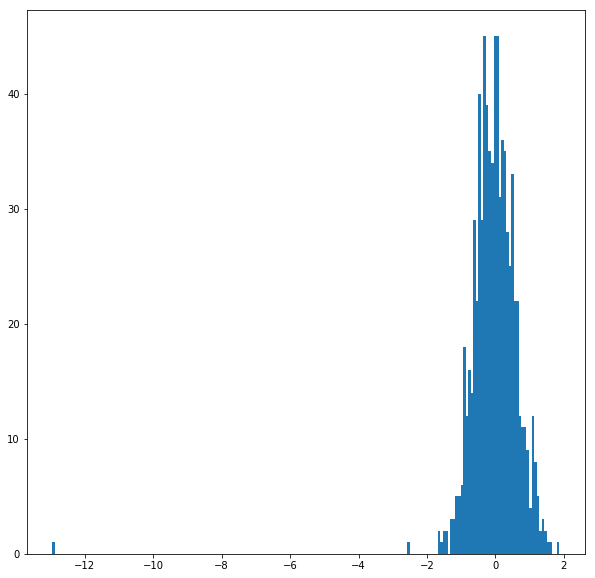

In [17]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token. 

Current dimensions:

`[# layers, # batches, # tokens, # features]`

Desired dimensions:

`[# tokens, # layers, # features]`

Luckily, PyTorch includes the `permute` function for easily rearranging the dimensions of a tensor. 

However, the first dimension is currently a Python list! 

In [18]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


Let's combine the 12 layers to make this one whole big tensor.

In [19]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()

torch.Size([12, 1, 22, 768])

Let's get rid of the "batches" dimension since we don't need it.

In [20]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([12, 22, 768])

Finally, we can switch around the "layers" and "tokens" dimensions with `permute`.

In [21]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 12, 768])

## 3.3. Creating word and sentence vectors from hidden states

Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 12 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors...but which layer or combination of layers provides the best representation? The BERT authors tested this by feeding different vector combinations as input features to a BiLSTM used on a named entity recognition task and observing the resulting F1 scores.

(Image from [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

While concatenation of the last four layers produced the best results on this specific task, many of the other methods come in a close second and in general it is advisable to test different versions for your specific application: results may vary.

This is partially demonstrated by noting that the different layers of BERT encode very different kinds of information, so the __appropriate pooling strategy will change depending on the application because different layers encode different kinds of information__. Hanxiao's discussion of this topic is relevant, as are their experiments looking at the PCA visualizations of different layers trained on a news dataset and observing the differences in the four class separations from different pooling strategies:

(Images from [Hanxiao's](https://github.com/hanxiao/bert-as-service) BERT-as-a-service)

![alt text](https://raw.githubusercontent.com/hanxiao/bert-as-service/master/.github/pool_mean.png)
![alt text](https://raw.githubusercontent.com/hanxiao/bert-as-service/master/.github/pool_max.png)

The upshot being that, again**, the correct pooling strategy (mean, max, concatenation, etc.) and layers used (last four, all, last layer, etc.) is dependent on the application**. This discussion of pooling strategies applies both to entire sentence embeddings and individual ELMO-like token embeddings.







### Word Vectors

To give you some examples, let's create word vectors two ways. 

First, let's **concatenate** the last four layers, giving us a single word vector per token. Each vector will have length `4 x 768 = 3,072`. 

In [22]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


As an alternative method, let's try creating the word vectors by **summing** together the last four layers.

In [23]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


### Sentence Vectors

To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [24]:
# `encoded_layers` has shape [12 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [25]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


## 3.4. Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let's look at the different instances of the word "bank" in our example sentence:

"After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**."

Let's find the index of those three instances of the word "bank" in the example sentence.

In [26]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


They are at 6, 10, and 19.

For this analysis, we'll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [27]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 2.1319, -2.1413, -1.6260,  0.8638,  3.3173])
bank robber   tensor([ 1.1868, -1.5298, -1.3770,  1.0648,  3.1446])
river bank    tensor([ 1.1295, -1.4725, -0.7296, -0.0901,  2.4970])


We can see that the values differ, but let's calculate the cosine similarity between the vectors to make a more precise comparison.

In [28]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.95
Vector similarity for *different* meanings:  0.68


This looks pretty good!

# 4. Appendix


## 4.1. Special tokens

It should be noted that although the `[CLS]` acts as an "aggregate representation" for classification tasks, this is not the best choice for a high quality sentence embedding vector. [According to](https://github.com/google-research/bert/issues/164) BERT author Jacob Devlin: "*I'm not sure what these vectors are, since BERT does not generate meaningful sentence vectors. It seems that this is is doing average pooling over the word tokens to get a sentence vector, but we never suggested that this will generate meaningful sentence representations*."

(However, the [CLS] token does become meaningful if the model has been fine-tuned, where the last hidden layer of this token is used as the "sentence vector" for sequence classification.)



## 4.2. Out of vocabulary words

For **out of vocabulary words** that are composed of multiple sentence and character-level embeddings, there is a further issue of how best to recover this embedding. Averaging the embeddings is the most straightforward solution (one that is relied upon in similar embedding models with subword vocabularies like fasttext), but summation of subword embeddings and simply taking the last token embedding (remember that the vectors are context sensitive) are acceptable alternative strategies.



## 4.3. Similarity metrics

It is worth noting that word-level **similarity comparisons** are not appropriate with BERT embeddings because these embeddings are contextually dependent, meaning that the word vector changes depending on the sentence it appears in. This allows wonderful things like polysemy so that e.g. your representation encodes river "bank" and not a financial institution "bank",  but makes direct word-to-word similarity comparisons less valuable. However, for sentence embeddings similarity comparison is still valid such that one can query, for example, a single sentence against a dataset of other sentences in order to find the most similar. Depending on the similarity metric used, the resulting similarity values will be less informative than the relative ranking of similarity outputs since many similarity metrics make assumptions about the vector space (equally-weighted dimensions, for example) that do not hold for our 768-dimensional vector space.


## 4.4. Implementations

You can use the code in this notebook as the foundation of your own application to extract BERT features from text. However, official [tensorflow](https://github.com/google-research/bert/blob/master/extract_features.py) and well-regarded [pytorch](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/extract_features.py) implementations already exist that do this for you.  Additionally, [bert-as-a-service](https://github.com/hanxiao/bert-as-service) is an excellent tool designed specifically for running this task with high performance, and is the one I would recommend for production applications. The author has taken great care in the tool's implementation and provides excellent documentation (some of which was used to help create this tutorial) to help users understand the more nuanced details the user faces, like resource management and pooling strategy.